<a href="https://www.kaggle.com/mishra5001/healthcare-problem-statement?scriptVersionId=88861583" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)+
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/av-healthcare-analytics-ii/healthcare/sample_sub.csv
/kaggle/input/av-healthcare-analytics-ii/healthcare/train_data_dictionary.csv
/kaggle/input/av-healthcare-analytics-ii/healthcare/train_data.csv
/kaggle/input/av-healthcare-analytics-ii/healthcare/test_data.csv


In [2]:
train_dataset = pd.read_csv('/kaggle/input/av-healthcare-analytics-ii/healthcare/train_data.csv')
test_dataset = pd.read_csv('/kaggle/input/av-healthcare-analytics-ii/healthcare/test_data.csv')

train_dataset.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


### Let me tell you what i am thinking.💭
For me this is a fun-weekend activity where i am looking at a MajorHealthcare sector problem.
How coool/feasibilie it will be if we get to **predict the hospitalization duration** for a particular patient, right?
We get to:  
- Better medical treatment🩺,
- Precise doctor management and maintaining work-life balance for healtchare-workers💕,
- Generate better revenues💰,
- Get more brand value under a Medical Sector⚡,
- Patient good review

I'll quickly think what we will try to inference out.
Primarily, want to focus on the below point:
- Categories present in target feature **stay**,
    - Find the **age** pattern, ✔
    - Which **department** requires longer stay? ✔
    - Which **hospital code**, on an average sees longer stay? ✔
    - Average **deposit amount** under each *stay category* ✔

In [3]:
print(f"Train Data:{train_dataset.shape}")
print(f"Test Data:{test_dataset.shape}")

Train Data:(318438, 18)
Test Data:(137057, 17)


In [4]:
train_dataset.describe()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,91925.276847,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,79610.250000,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,159219.500000,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,238828.750000,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,318438.000000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


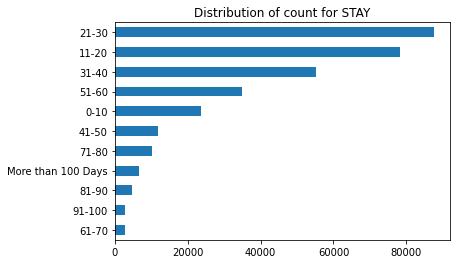

In [5]:
# I though instead of showing values, let's look at a graph and directly infer!
train_dataset.Stay.value_counts(ascending=True).plot(kind = 'barh');
plt.title('Distribution of count for STAY');

In [6]:
# For each Stay Category, trying to look for the AGE distribution
stay_age_distribution = pd.get_dummies(train_dataset.loc[:,['Stay','Age']], columns=['Age']).groupby('Stay', as_index=False).sum()
stay_age_distribution

,Stay,Age_0-10,Age_11-20,Age_21-30,Age_31-40,Age_41-50,Age_51-60,Age_61-70,Age_71-80,Age_81-90,Age_91-100
0,0-10,615.0,1552.0,3467.0,4916.0,4727.0,3427.0,2194.0,2201.0,422.0,83.0
1,11-20,1959.0,5343.0,11272.0,15792.0,14959.0,11346.0,7870.0,7958.0,1392.0,248.0
2,21-30,1489.0,4312.0,11394.0,18550.0,17906.0,13058.0,9033.0,9534.0,1920.0,295.0
3,31-40,1014.0,2681.0,6912.0,10912.0,10983.0,8569.0,5930.0,6420.0,1504.0,234.0
4,41-50,187.0,510.0,1398.0,2373.0,2507.0,1735.0,1205.0,1383.0,379.0,66.0
5,51-60,582.0,1429.0,3793.0,6517.0,7189.0,5739.0,4081.0,4433.0,1082.0,173.0
6,61-70,26.0,89.0,263.0,509.0,562.0,448.0,325.0,378.0,115.0,29.0
7,71-80,153.0,350.0,1026.0,1807.0,2146.0,1710.0,1230.0,1367.0,402.0,63.0
8,81-90,84.0,223.0,546.0,801.0,885.0,784.0,600.0,670.0,216.0,29.0
9,91-100,35.0,71.0,231.0,484.0,578.0,499.0,330.0,386.0,132.0,19.0


In [7]:
now = stay_age_distribution.columns.tolist()
now.remove('Stay')
print(now)

['Age_0-10', 'Age_11-20', 'Age_21-30', 'Age_31-40', 'Age_41-50', 'Age_51-60', 'Age_61-70', 'Age_71-80', 'Age_81-90', 'Age_91-100']


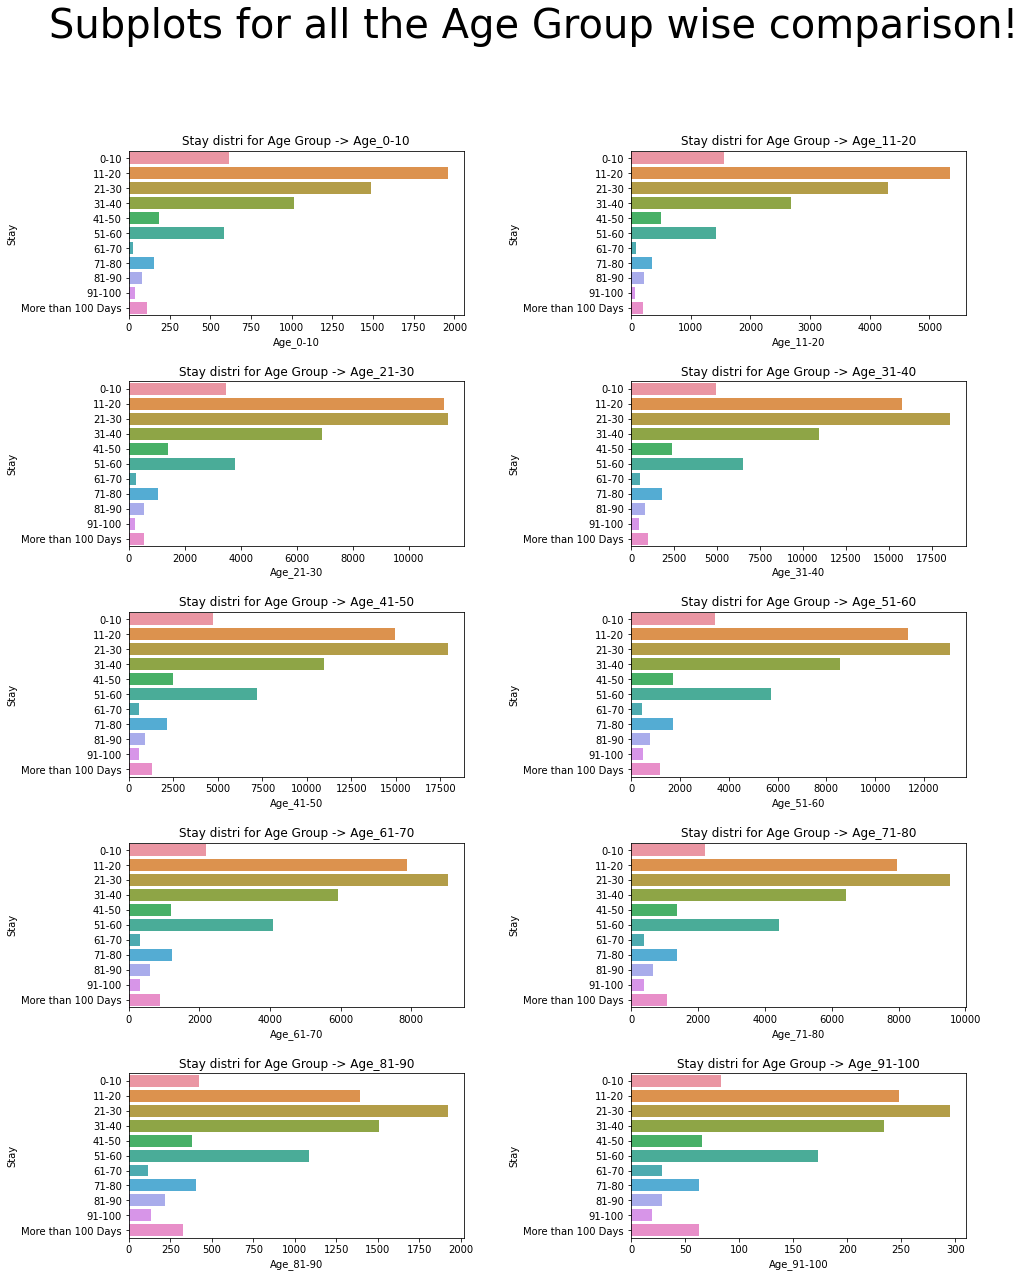

In [8]:
plt.figure(figsize=(15,20))
plt.suptitle("Subplots for all the Age Group wise comparison!", fontsize=40)
x = 1
for age in now:
    ax = plt.subplot(int(len(now)//2),2,x)
    ax = plt.subplots_adjust(wspace=0.5,hspace=0.4)
    sns.barplot(y = 'Stay',x = age,data = stay_age_distribution,ax = ax)
    plt.title(f'Stay distri for Age Group -> {age}')
    x +=1

So, we can see that the Stay duration of **21-30** days, is highly prominent, which makes it very much curious to me as of what health-problems do generally people come in with that it takes more than 3 weeks to get resolved.

As far as Age pattern is concerend, now let's focus on two Stay - durations:
1. 21-30 days
2. 51-60 days.

##### Why these two, you may ask ⁉⁉
- Well, obvious with the first duration, where as for the second one, want to se wether the same inferences apply for a 2 Months period of time!?

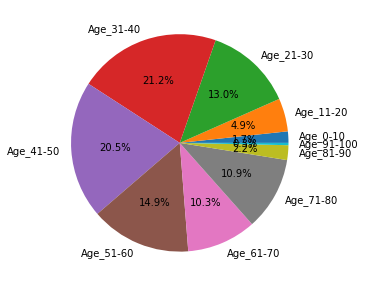

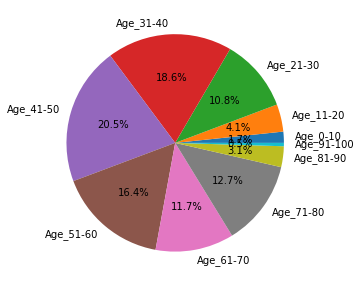

In [9]:
stay_durations = ['21-30','51-60']
stay_specific_data = stay_age_distribution[stay_age_distribution.Stay.isin(stay_durations)].reset_index(drop=True).iloc[:,1:]
for ind in stay_specific_data.index:
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    # print(stay_specific_data.iloc[ind])
    stay_specific_data.iloc[ind].plot(kind='pie', ax=ax, autopct='%1.1f%%')
    ax.set_ylabel('')
    ax.set_xlabel('')

So, the first pie-chart is the distribution for **21-30** days, and succeeding one is for **51-60** days.
- The two Age Slots heavily dominating are:
    - Age 31-40
    - Age 41-50
    
    I believe, these 20 years are the phase where we move into our adulthood and all the poison we consumed till 30's startes to kick-in.
    Poison:
        - Toxic breathing
        - Liqour/Smoking🚬
        - Junk/un-healthy food🍜/🍕
        
Now, for these two age groups and Stay of days respectively, let's find out the type of Department they are treated in!

In [10]:
dep_stay_age_distri = train_dataset.groupby(by = ['Stay','Age','Department'])['Department'].count().reset_index(level = 1)
dep_stay_age_distri

Age  Department
Stay               Department                            
0-10               TB & Chest disease    0-10          35
                   anesthesia            0-10          41
                   gynecology            0-10         449
                   radiotherapy          0-10          80
                   surgery               0-10          10
...                                       ...         ...
More than 100 Days radiotherapy         81-90          55
                   TB & Chest disease  91-100           1
                   anesthesia          91-100           3
                   gynecology          91-100          48
                   radiotherapy        91-100          11

[529 rows x 2 columns]

In [11]:
dur_21_30 = dep_stay_age_distri[dep_stay_age_distri.index.get_level_values('Stay').isin([stay_durations[0]])].rename(columns = {'Department':'Count of patients'}).reset_index(level=1)
dur_51_60 = dep_stay_age_distri[dep_stay_age_distri.index.get_level_values('Stay').isin([stay_durations[1]])].rename(columns = {'Department':'Count of patients'}).reset_index(level=1)

In [12]:
dur_21_30.head()

,Department,Age,Count of patients
Stay,,,
21-30,TB & Chest disease,0-10,100
21-30,anesthesia,0-10,119
21-30,gynecology,0-10,1021
21-30,radiotherapy,0-10,227
21-30,surgery,0-10,22


In [13]:
dur_51_60.head()

,Department,Age,Count of patients
Stay,,,
51-60,TB & Chest disease,0-10,37
51-60,anesthesia,0-10,39
51-60,gynecology,0-10,397
51-60,radiotherapy,0-10,97
51-60,surgery,0-10,12


At this moment, we can see patient count against each age group for each department, let's try to figure out the Total count of patients across departments only, as that is the main goal, right!

In [14]:
total_21_30 = dur_21_30.groupby('Department')['Count of patients'].sum()
total_51_60 = dur_51_60.groupby('Department')['Count of patients'].sum()
total_21_30

Department
TB & Chest disease     2618
anesthesia             8950
gynecology            68383
radiotherapy           7263
surgery                 277
Name: Count of patients, dtype: int64

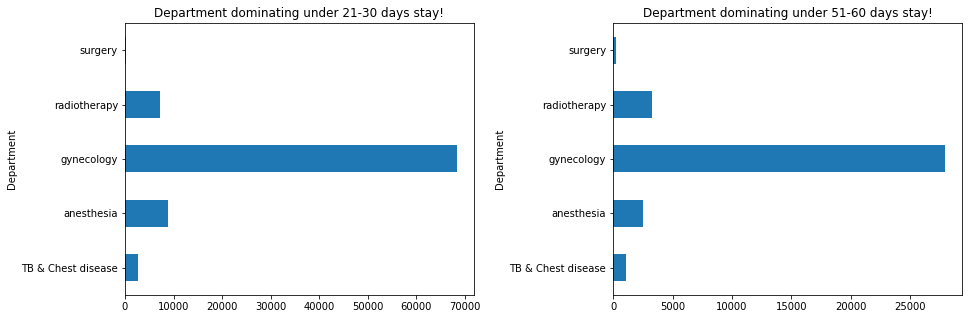

In [15]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.4,hspace=0.3)
total_21_30.plot(kind = 'barh');
plt.title('Department dominating under 21-30 days stay!');
plt.subplot(1,2,2)
total_51_60.plot(kind = 'barh');
plt.title('Department dominating under 51-60 days stay!');

**`Gynecology department leads all the way!`.**  
Hmm, now this is making me think, <u>precisely what kind of issues under this category occurs, which may extend 30 days stay to 60 days stay!🤔</u>
- Let me know some technical pointers on this in the comment section!!  

Now, moving onto the **Hospital Code** which sees longer stays. Well, i have thought of using only the above two durations are primary comparison analysis for this.
So, the question becomes now that which Hospital Codes sees highest demands for:
1. 21-30 days stay
2. 51-60 days stay

- I am hoping the Codes to be turning out same, coz this will reflect that the ***Hospital capable of handling 30 days stay, is indeed capable of Handling 60 days stay also!***, i might be wrong, let's find out!

In [16]:
# Let's create master df which only contains the recorss for these 2 durations only!
master_duration_df = train_dataset[train_dataset['Stay'].isin(stay_durations)]
master_duration_df

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
8,9,1,d,10,Y,2,gynecology,R,B,4.0,31397,7.0,Trauma,Extreme,2,51-60,7223.0,51-60
10,11,22,g,9,Y,2,radiotherapy,S,B,2.0,31397,7.0,Urgent,Extreme,2,51-60,5797.0,21-30
13,14,9,d,5,Z,3,radiotherapy,S,F,3.0,31397,7.0,Urgent,Extreme,2,51-60,8477.0,21-30
18,19,32,f,9,Y,4,radiotherapy,S,B,2.0,63418,8.0,Trauma,Extreme,2,71-80,7442.0,21-30
21,22,3,c,3,Z,2,anesthesia,R,A,3.0,63418,8.0,Trauma,Extreme,2,71-80,6672.0,21-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318408,318409,22,g,9,Y,2,gynecology,S,B,2.0,84463,8.0,Trauma,Moderate,2,11-20,3930.0,51-60
318409,318410,30,c,3,Z,2,surgery,R,A,4.0,102826,7.0,Emergency,Moderate,3,41-50,8937.0,21-30
318417,318418,15,c,5,Z,4,gynecology,Q,F,4.0,104580,4.0,Urgent,Minor,2,21-30,4819.0,21-30
318430,318431,6,a,6,X,3,anesthesia,Q,F,4.0,109796,8.0,Trauma,Moderate,2,41-50,5065.0,21-30


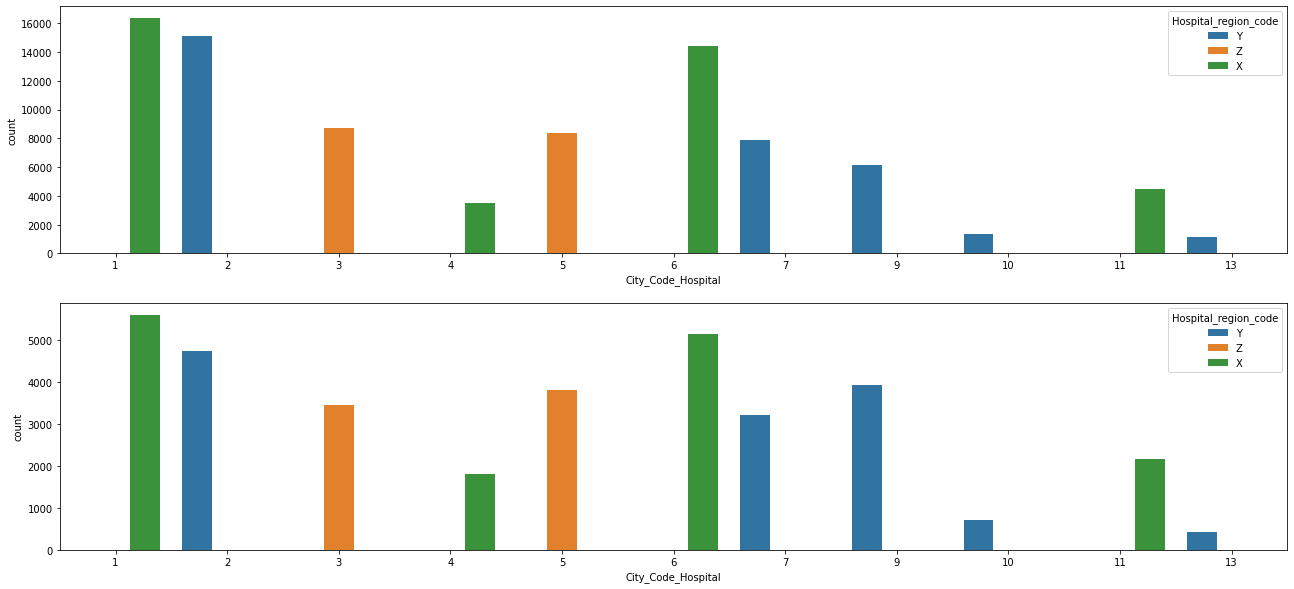

In [17]:
# Using the above master df, now i can even see the Severity of illeness duration wise
hospital_region_code_21_30 = master_duration_df[master_duration_df.Stay == '21-30']
hospital_region_code_51_60 = master_duration_df[master_duration_df.Stay == '51-60']
plt.figure(figsize=(22,10))
plt.subplot(2,1,1)
sns.countplot(hue = hospital_region_code_21_30['Hospital_region_code'],x = hospital_region_code_21_30['City_Code_Hospital']);
plt.subplot(2,1,2)
sns.countplot(hue = hospital_region_code_51_60['Hospital_region_code'],x = hospital_region_code_51_60['City_Code_Hospital']);

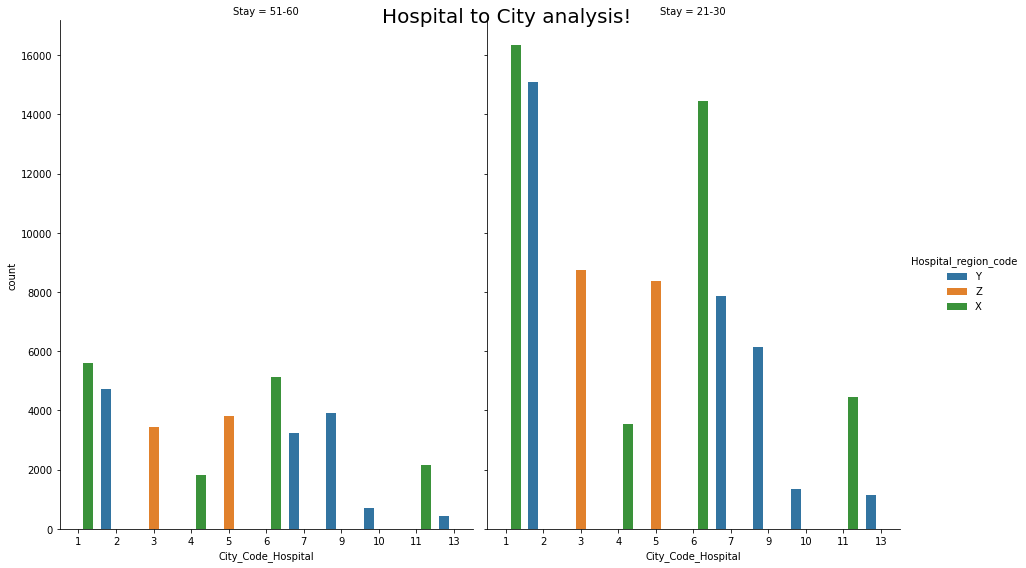

In [18]:
g = sns.catplot(hue="Hospital_region_code", x="City_Code_Hospital", col="Stay",
                data=master_duration_df, kind="count",
                height=8, aspect=.8);
plt.suptitle('Hospital to City analysis!',fontsize = 20);

Well at first i thought that the above 2 BAR chart subplot looks like mirror and something is wrong, but the below image clears the clouds, well, it is the scale on which the Stay durations are measure out of!
- The count scale for Stay 21-30 is upto 16k, whereas for Stay 51-60 is upto 5k only.

Which brings to the conclusion i was looking for:
- The *Hospital Region* **X** with *City code* **1** has seen the highest count, for both the <u>duration of Stays</u>, followed by City Code 6 under the same Hospital Region!.
- ***`This may not confirm the evidence that the duration gets extended in the same hospital zone/area/perimiter, but strongly indicates in that direction.`***, let's confirm this with the Severitty of Illness and maybe by type of admission

In [19]:
# I actually missed checking the duplicate entries
master_duration_df[master_duration_df.duplicated(subset = ['case_id'])]

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay


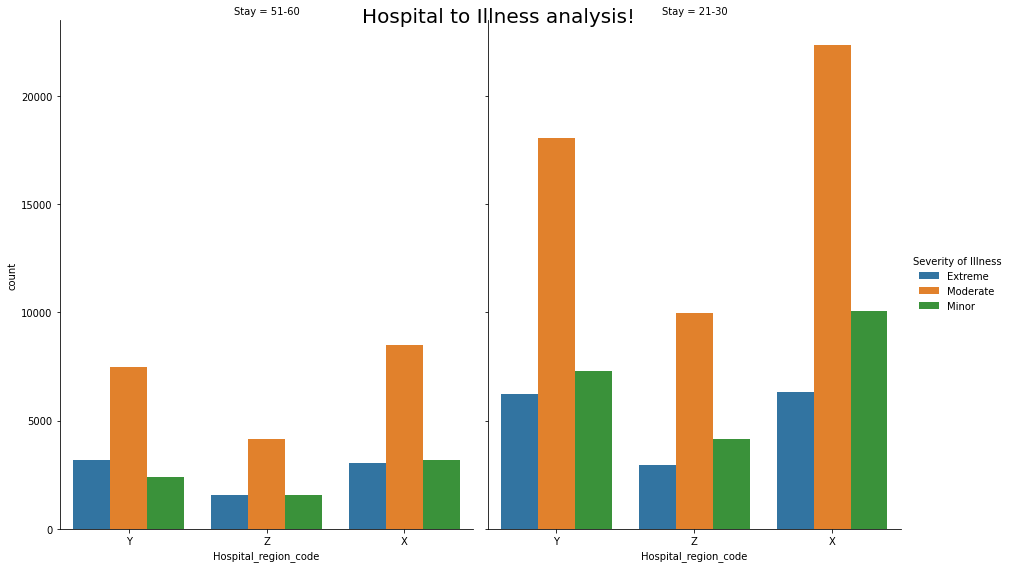

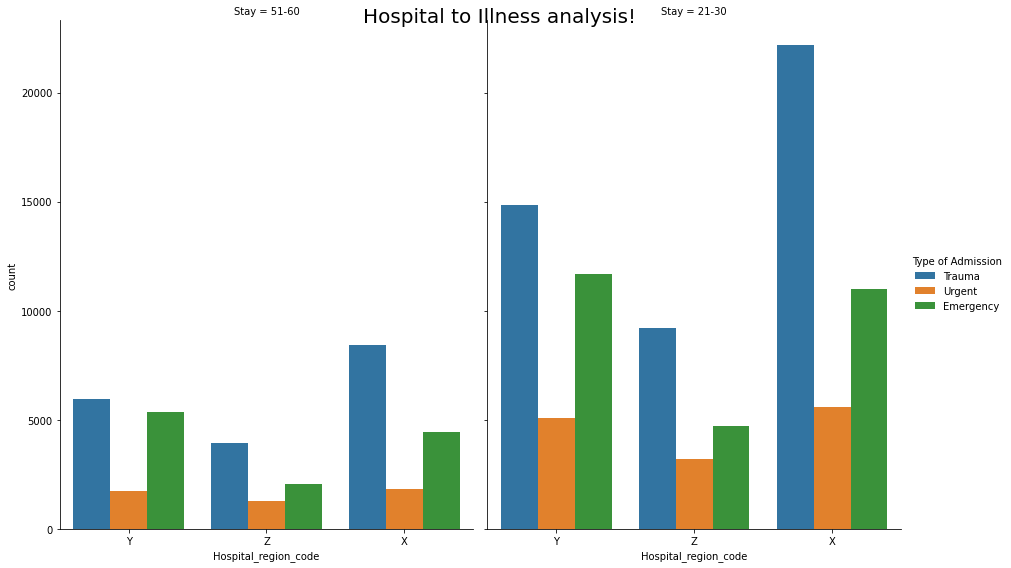

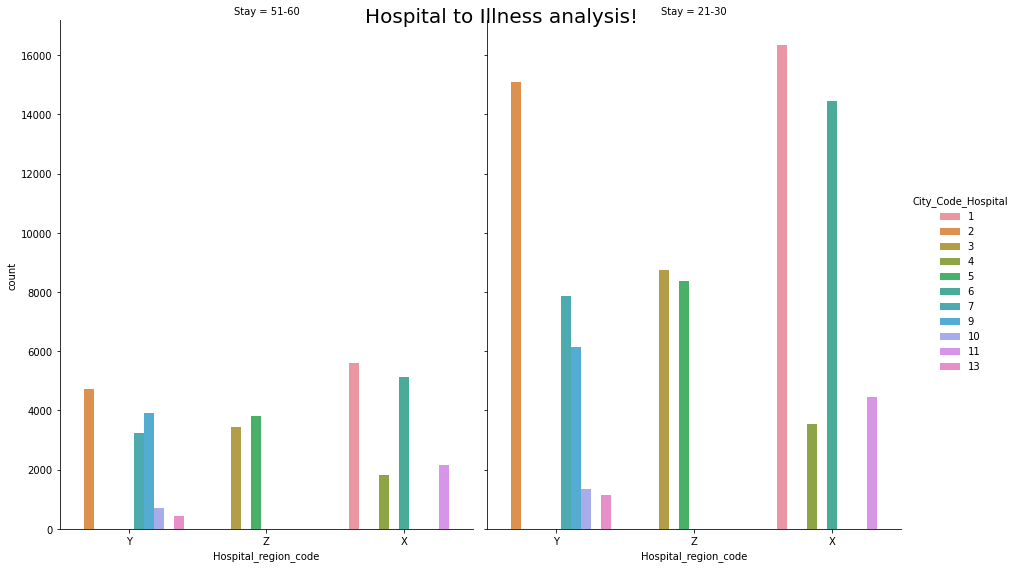

In [20]:
# SO, now will try to see against illness severity and type of admission!
g = sns.catplot(hue="Severity of Illness", x="Hospital_region_code", col="Stay",
                data=master_duration_df, kind="count",
                height=8, aspect=.8);
plt.suptitle('Hospital to Illness analysis!',fontsize = 20);

g = sns.catplot(hue="Type of Admission", x="Hospital_region_code", col="Stay",
                data=master_duration_df, kind="count",
                height=8, aspect=.8);
plt.suptitle('Hospital to Illness analysis!',fontsize = 20);

g = sns.catplot(hue="City_Code_Hospital", x="Hospital_region_code", col="Stay",
                data=master_duration_df, kind="count",
                height=8, aspect=.8);
plt.suptitle('Hospital to Illness analysis!',fontsize = 20);

Now, looking at these charts, i can definitely say, that there are two reasons why i am confident now that:
- The patient treatment started with 21-30 days treatment generally gets extended to 50 weeks,
    - More creamy way would be say that, ***`patient predicted to get treated in 3 weeks, gets extended to 5-6 weeks`***, given that the case is of **Trauma and Severity is Extreme/Moderate**.
    - Well, given the current situation the world is going through, till date have seen pandemic **Covid-19, Afghanistan situation, and Russia vs Ukraine battle,** the whole world is in **Trauma!**
- The Hospital Regions **X and Y** have more visibility than **Z**, so patients feel comfortable in extending their treatment!

#### Now, let's try to find the Average Admission amount per Stay duration category!

In [21]:
avg_admission_amount = train_dataset.groupby(by = ['Stay','Severity of Illness'])['Admission_Deposit'].mean().reset_index()
avg_admission_amount

,Stay,Severity of Illness,Admission_Deposit
0,0-10,Extreme,4508.653427
1,0-10,Minor,4692.847063
2,0-10,Moderate,4595.078856
3,11-20,Extreme,4787.106104
4,11-20,Minor,5024.140911
5,11-20,Moderate,4906.354736
6,21-30,Extreme,4892.911882
7,21-30,Minor,5142.542512
8,21-30,Moderate,5015.952214
9,31-40,Extreme,4765.498017


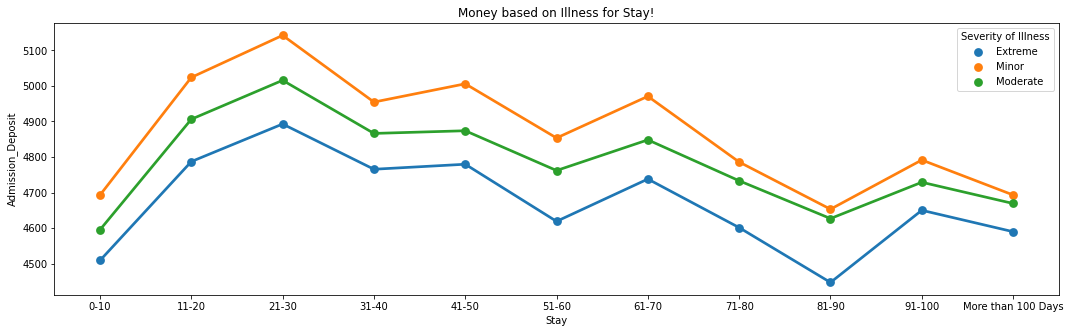

In [22]:
plt.figure(figsize=(18,5))
sns.pointplot(data=avg_admission_amount, y="Admission_Deposit", x="Stay",hue = 'Severity of Illness');
plt.title('Money based on Illness for Stay!');

Let me tell you if you face a MINOR severity, you need to deposit more money apparently! 😆😆😆😆😆
- But i can infer, one more thning, the LONG STAY of around 81 to 90 days, require less amount to be deposited, around 4.5k, but ibelieve, that's where the `Medical Insurance` kicks in as the amount can be settled as the treatment reaches end!


### So, all our EDA's are done,✅
- We saw, most prominent Admitting duration(s) are:
    - ***`21-30 and 51-60 days.`***
- Most of the Patients under these two SOD are being treated in ***`Gynecology department`***
- ***`Most cases of average 3 weeks are getting extended to 5 weeks duration.`***
- Mostly the converted cases are of ***`Trauma with Moderate/Extreme`*** severity!
- Finally, looks like if the case is of Extreme condition, ***`Medical Insurance kicks in and the admission average money is comparitvely low`***

### Now, let's move towards Data-Engineering part and prepare a Dataset suitable for predicting `SOD`

In [23]:
train_dataset = train_dataset.drop(columns = 'case_id')
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Hospital_code                      318438 non-null  int64  
 1   Hospital_type_code                 318438 non-null  object 
 2   City_Code_Hospital                 318438 non-null  int64  
 3   Hospital_region_code               318438 non-null  object 
 4   Available Extra Rooms in Hospital  318438 non-null  int64  
 5   Department                         318438 non-null  object 
 6   Ward_Type                          318438 non-null  object 
 7   Ward_Facility_Code                 318438 non-null  object 
 8   Bed Grade                          318325 non-null  float64
 9   patientid                          318438 non-null  int64  
 10  City_Code_Patient                  313906 non-null  float64
 11  Type of Admission                  3184

In [24]:
# So, as we are aware, we need to convert all our OBJECT columns to numerical, but i wan't to take decision, based upon the LEVELS present!
for col in train_dataset.columns.tolist():
    if train_dataset[col].dtype == 'O':
        print(f"{col} has:")
        print(train_dataset[col].unique(),'\n')

Hospital_type_code has:
['c' 'e' 'b' 'a' 'f' 'd' 'g'] 

Hospital_region_code has:
['Z' 'X' 'Y'] 

Department has:
['radiotherapy' 'anesthesia' 'gynecology' 'TB & Chest disease' 'surgery'] 

Ward_Type has:
['R' 'S' 'Q' 'P' 'T' 'U'] 

Ward_Facility_Code has:
['F' 'E' 'D' 'B' 'A' 'C'] 

Type of Admission has:
['Emergency' 'Trauma' 'Urgent'] 

Severity of Illness has:
['Extreme' 'Moderate' 'Minor'] 

Age has:
['51-60' '71-80' '31-40' '41-50' '81-90' '61-70' '21-30' '11-20' '0-10'
 '91-100'] 

Stay has:
['0-10' '41-50' '31-40' '11-20' '51-60' '21-30' '71-80'
 'More than 100 Days' '81-90' '61-70' '91-100'] 



***`Nominal Variable (Categorical). Variable comprises a finite set of discrete values with no relationship between values.`***   
***`Ordinal Variable. Variable comprises a finite set of discrete values with a ranked ordering between values.`***

So, if i am right, we have Nominal features:
- Hospital code
- Hospital Region code
- Department
- Ward Facility code
- Type of Admission
whereas, the Ordinal Features are:
- Severity of Illness
- Age

So, Encoding of Features needs to be tackled appropriately!
- For Nominal Features, will use **Dummy/One-Hot Encdoing!,**
- For ordinal Features, will use **Ordinal Encoder Transformer**  

Resource: https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

In [25]:
nominal_features = ['Hospital_type_code','Hospital_region_code','Department','Ward_Type','Ward_Facility_Code','Type of Admission']
ordinal_features = ['Severity of Illness','Age']

In [26]:
# One-Hot encoding of Nominal Features!

def one_hot_encode(dataset,features):
    nominal_df = dataset[features]

    # convert into dummies
    nominal_dummies = pd.get_dummies(nominal_df, drop_first=False)
    # drop categorical variables 
    dataset = dataset.drop(list(nominal_df.columns), axis=1)
    # concat dummy variables with X
    dataset = pd.concat([dataset, nominal_dummies], axis=1)
    return dataset

de_1_df = one_hot_encode(train_dataset,nominal_features)
de_1_df.head()

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,...,Ward_Type_U,Ward_Facility_Code_A,Ward_Facility_Code_B,Ward_Facility_Code_C,Ward_Facility_Code_D,Ward_Facility_Code_E,Ward_Facility_Code_F,Type of Admission_Emergency,Type of Admission_Trauma,Type of Admission_Urgent
0,8,3,3,2.0,31397,7.0,Extreme,2,51-60,4911.0,...,0,0,0,0,0,0,1,1,0,0
1,2,5,2,2.0,31397,7.0,Extreme,2,51-60,5954.0,...,0,0,0,0,0,0,1,0,1,0
2,10,1,2,2.0,31397,7.0,Extreme,2,51-60,4745.0,...,0,0,0,0,0,1,0,0,1,0
3,26,2,2,2.0,31397,7.0,Extreme,2,51-60,7272.0,...,0,0,0,0,1,0,0,0,1,0
4,26,2,2,2.0,31397,7.0,Extreme,2,51-60,5558.0,...,0,0,0,0,1,0,0,0,1,0


In [27]:
# ordinal encode input variables
from sklearn.preprocessing import OrdinalEncoder

ordinal = OrdinalEncoder()
ordinal_series = ordinal.fit_transform(de_1_df[['Severity of Illness']])
de_2_df = de_1_df.drop(columns= ordinal_features)
de_2_df['Severity of Illness'] = ordinal_series
de_2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Hospital_code                      318438 non-null  int64  
 1   City_Code_Hospital                 318438 non-null  int64  
 2   Available Extra Rooms in Hospital  318438 non-null  int64  
 3   Bed Grade                          318325 non-null  float64
 4   patientid                          318438 non-null  int64  
 5   City_Code_Patient                  313906 non-null  float64
 6   Visitors with Patient              318438 non-null  int64  
 7   Admission_Deposit                  318438 non-null  float64
 8   Stay                               318438 non-null  object 
 9   Hospital_type_code_a               318438 non-null  uint8  
 10  Hospital_type_code_b               318438 non-null  uint8  
 11  Hospital_type_code_c               3184

In [28]:
# I see some NULL VALUES, hold on!
round(de_2_df.isnull().sum()/len(de_2_df),3)

Hospital_code                        0.000
City_Code_Hospital                   0.000
Available Extra Rooms in Hospital    0.000
Bed Grade                            0.000
patientid                            0.000
City_Code_Patient                    0.014
Visitors with Patient                0.000
Admission_Deposit                    0.000
Stay                                 0.000
Hospital_type_code_a                 0.000
Hospital_type_code_b                 0.000
Hospital_type_code_c                 0.000
Hospital_type_code_d                 0.000
Hospital_type_code_e                 0.000
Hospital_type_code_f                 0.000
Hospital_type_code_g                 0.000
Hospital_region_code_X               0.000
Hospital_region_code_Y               0.000
Hospital_region_code_Z               0.000
Department_TB & Chest disease        0.000
Department_anesthesia                0.000
Department_gynecology                0.000
Department_radiotherapy              0.000
Department_

In [29]:
print(f"Before dropping NA's {de_2_df.shape}")
init = de_2_df.shape[0]
de_2_df = de_2_df.dropna(axis = 0)
print(f"After dropping NA's {de_2_df.shape}")
after = de_2_df.shape[0]
print(f"% difference = {((init-after)/init)*100}")

Before dropping NA's (318438, 40)
After dropping NA's (313793, 40)
% difference = 1.4586826949045026


Small, amount of missing, data, i will just drop those rows!😋  
Finally, we have reached to the point where all the features are prepared and we would like to see the Correlation and pairing among the features!

<AxesSubplot:>

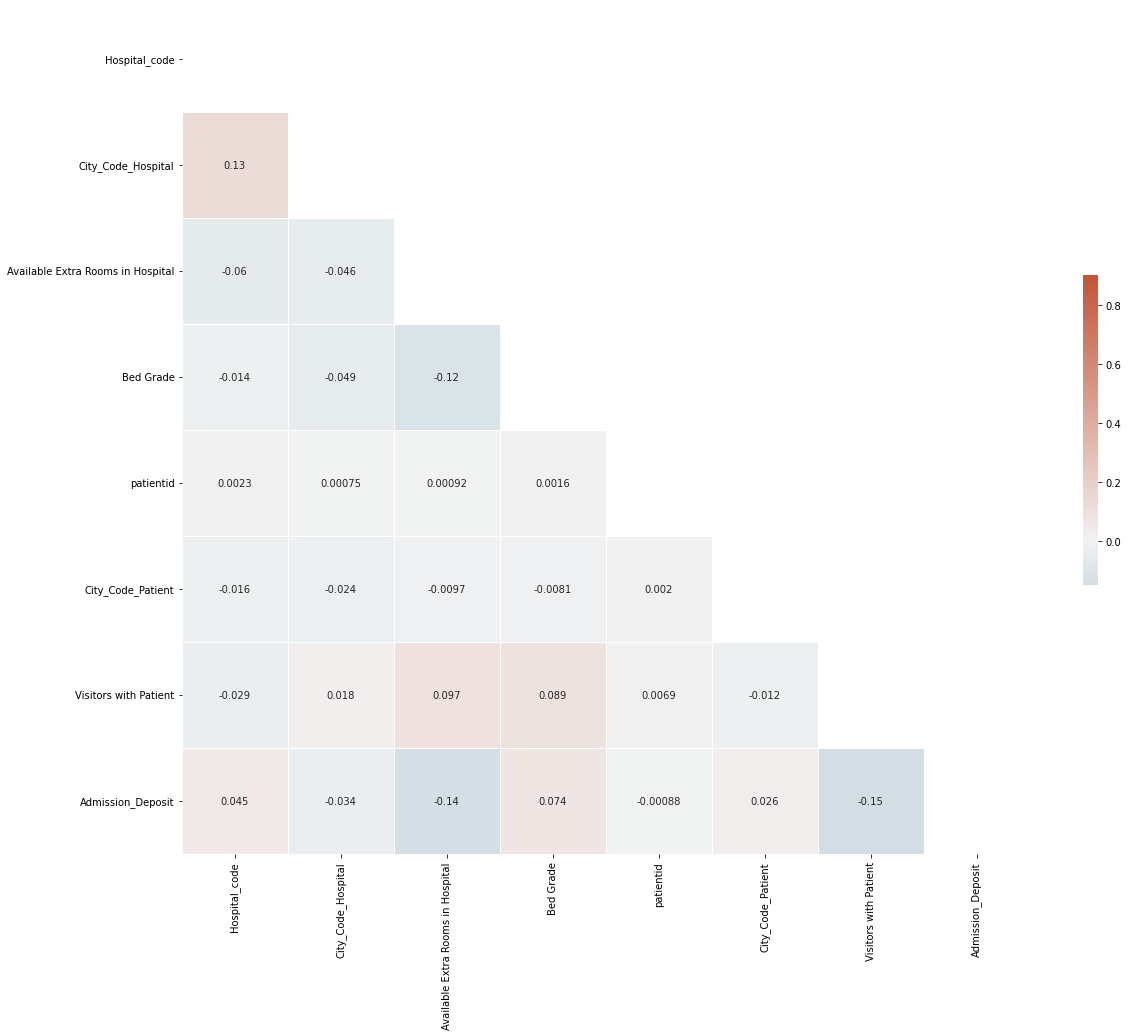

In [30]:
# correlation matrix
corr = train_dataset.corr()
# heatmap
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(19, 19))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.7, cbar_kws={"shrink": .3},annot=True)

<Figure size 1440x720 with 0 Axes>

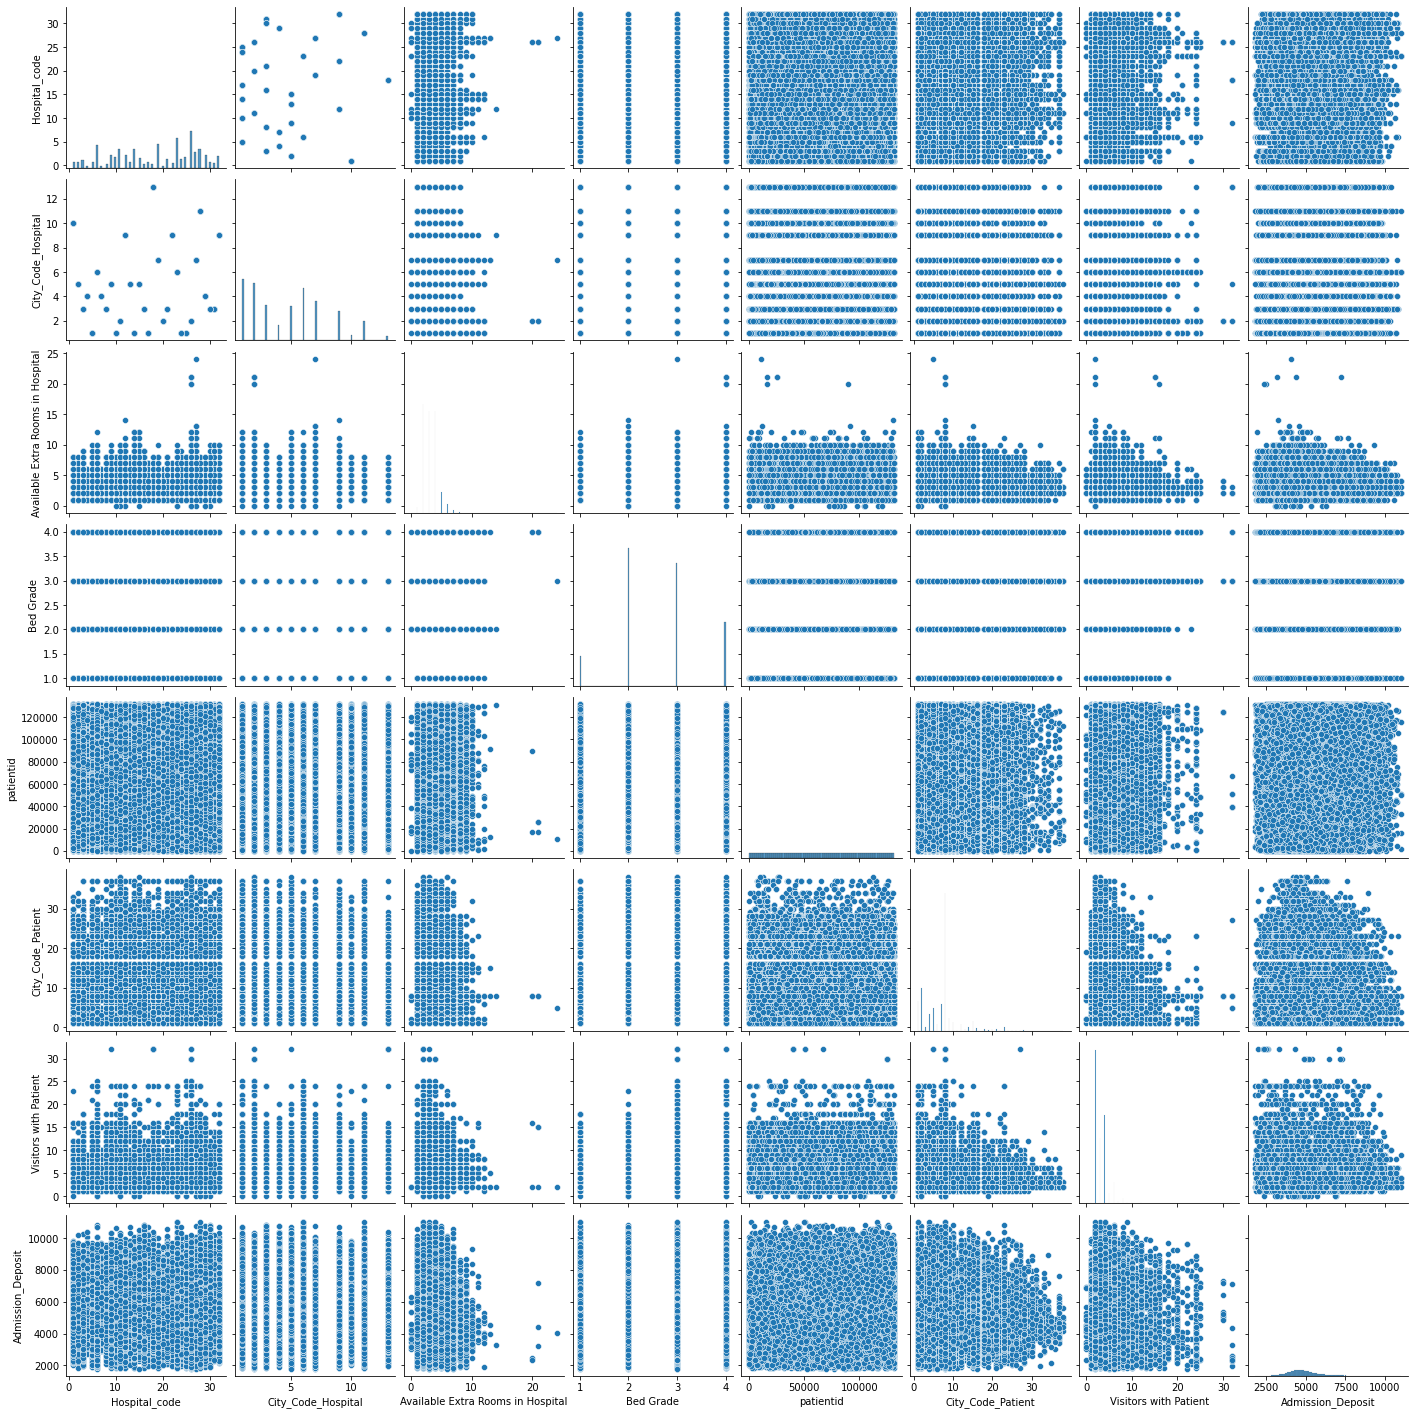

In [31]:
# paiwise scatter plot

plt.figure(figsize=(20, 10))
sns.pairplot(train_dataset)
plt.show()

Ok, now ur DE part is almost dne, with just ne step to Label Encode the Target Variable. Reason behind this:
- To bring the dataset ALL NUMERICAL tabular data, suitable for:
    - Over/Undersampling
    - Scaling
    - Modelling

Aah, **Sampling** hnn!
Let me have a look at the STAY feature count distribution, level based

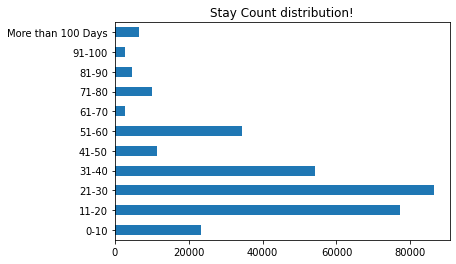

In [32]:
de_2_df.Stay.value_counts().sort_index().plot(kind = 'barh');
plt.title('Stay Count distribution!');

Oh, we can see that the data favours more towards `11-20 SOD and 21-30 SOD`,respectively.
We was thinking of doing some SAMPLING strategy and using SMOTE oversampling, we should be able to generate some synthetic data.

Used too many **We's** na,😄, well there are two people behind this notebook:
- ***`You who is reading this!`***
- ***`Myself motivated, that i am worth your reading time.`***🙌

### <u><b>Asking UPVOTE🔝 for 0% Equity in exchange of 100% LOVE</b></u>💛

In [33]:
# LabelEncdoing the Target-Feature
LabelEncode = LabelEncoder()
de_2_df['Stay'] = LabelEncode.fit_transform(de_2_df['Stay'])
de_2_df.Stay.value_counts(sort=True)

2     86316
1     77095
3     54312
5     34463
0     23250
4     11541
7     10096
10     6548
8      4761
9      2713
6      2698
Name: Stay, dtype: int64

In [34]:
# Oversampling the Dataset!
X = de_2_df.drop(columns= ['Stay'])
y = de_2_df[['Stay']]

rbs = RobustScaler()
X = rbs.fit_transform(X)

In [35]:
def oversample_split(X,y,strategy):
    # transform the dataset
    oversample = SMOTE(sampling_strategy=strategy)
    X_sample, y_sample = oversample.fit_resample(X, y)
    print(y_sample.value_counts())
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)
    return X_train, X_test, y_train, y_test

strategy = {0: 24000, 4:40000, 10:10000, 8: 10000, 9: 10000, 6: 10000 }
X_train, X_test, y_train, y_test = oversample_split(X,y,strategy)

print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

Stay
2       86316
1       77095
3       54312
4       40000
5       34463
0       24000
7       10096
6       10000
8       10000
9       10000
10      10000
dtype: int64
X_train Shape: (219655, 39)
X_test Shape: (94138, 39)
y_train Shape: (219655, 1)
y_test Shape: (94138, 1)


I was silent for the moment, as we have finally reached the Modelling Part.

# ML Model for Multi-Class Classification
3 Sets of Models i am targetting:
- Random Forest
    - With and without Hyper-tuning
- XGBoost
    - with and without Hyper-tuning
- LGBM 
    - without hyper-tuning
    

## Talking breifly about each Model:
<h3>Random Forest</h3>
- Tree based Algorithm works on bagging technique
    -  This is a theoretical foundation that shows that sampling with replacement and then building an ensemble reduces the variance of the forest without increasing the bias.
    - Prediction is aggregated across multiple trees which donot have any connection while learning.
    

<h3>XGBoost</h3>

<h3>LGBM</h3>

In [36]:
def random_forest(train,test):
    '''
    TODO : Random Forest Model Architecture
    '''
    return rf_model

def xgboost(train,test):
    
    '''
    TODO: XGBoost Model Architecture
    '''
    return xgboot_model

def lgbm(train,test):
    '''
    TODO: LightGBM Model Architecture
    '''
    return lgbm_model


# That's it for Sunday Guys

#### Phase 1:
- 25<sup>th</sup> feb to 27<sup>th</sup> feb

#### Phase 2:
- 5<sup>th</sup> march to 6<sup>th</sup> march

Upvote!🔼